#  Fairness and Explainability
This lab is divided into two parts.
1. Fairness: We will assess the fairness of a credit scoring model
2. Explainability: We will use the 'shap' library to generate explanations for the language model in the lab for Chapter 3.

The two parts are independent meaining that the imports and code from one are not necessary to run the other.
We start with fairness


## Part 1: Fairness

We start by importing necessary libraries and functions.

In [ ]:
import numpy as np
import pandas as pd

import fairlearn
# Plots
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
%matplotlib inline

from functools import partial

import fairlearn
from fairlearn.metrics import (
    MetricFrame,
    count,
    equalized_odds_difference,
    false_negative_rate,
    false_positive_rate,
    true_negative_rate,
    true_positive_rate,
    selection_rate,
)

from sklearn.metrics import accuracy_score, precision_score


In this section we will focus on assesing fairness of a credit scoring model.
For this exercise we are going to assume we have already trained the model using variables such as income, credit score and interest rates. The target variable as two values that is, non-default, indicated by 0, and default, inidcated by 1.

We are interested to know if this credit scoring model discriminates agains the sensitive attribute which is one of the variables. This variable is a proxy for race, so in essence we are measuring fairness with respect to the race of the people applying for credit.
Race is a protected characteristic by law and can therefore not be used when training the model. There may however be hidden confounding variables, which make the model unfair. Our goal is to assess this.

A dataset containing the neccessary information has been prepared

We start by reading in the dataset, which contains four variables:
- 'true_label': This it the ground truth label, that is, whether the customer defaulted or not.
- Predicted label: The label which the model predicts: 'predicted_label'
- 'predicted_probability'.  The probability of default predicted by the model. This is a number between 0 and 1.
- 'sensitive_attribute': The sensitive attribute in the dataset which we want to study from the perspective of fairness. This variable has four levels
  - 'a'
  - 'b'
  - 'c'
  - 'd'   

Note that the dataset was created for this exercise using mortgages with majorities from different ethnic profiles, using the first three digits of the postcode and census information.
This should not be considered a representative sample of those sectors. It is an illustrative example of the techniques and methods, not a showcase of differences in these places.

We start by reading in and inspecting the dataset.

In [ ]:
# Read in the data
fairness_df=pd.read_csv('FairnessDataFrame.csv')
fairness_df.describe()

,true_label,predicted_label,predicted_probability,credit_score
count,6983.000000,6983.000000,6983.000000,6983.000000
mean,0.025490,0.268509,0.345760,746.887298
std,0.157621,0.443216,0.228219,46.599742
min,0.000000,0.000000,0.036601,616.000000
25%,0.000000,0.000000,0.147221,713.000000
50%,0.000000,0.000000,0.290554,755.000000
75%,0.000000,1.000000,0.519864,786.000000
max,1.000000,1.000000,0.851339,829.000000


We look at the distribution of the groups in the sensitive attribute. The barplot below shows that most people belong to group 'b', followed by group 'c' and then 'a' and 'd' which have similar counts.
We also calculate the default rate per group and see that group 'b' has the highest default rate and gorup 'c' the lowest, whereas groups 'a' and 'd' are similar.

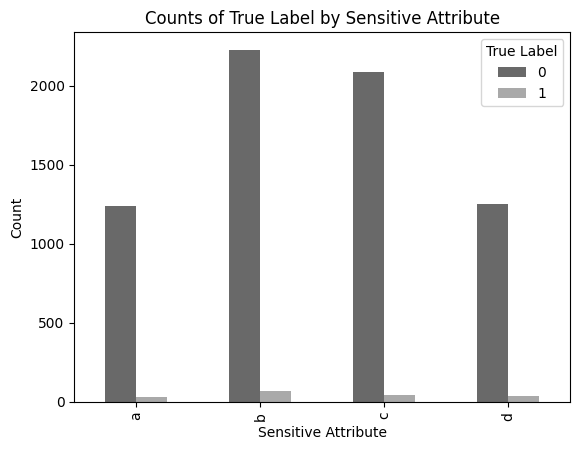

sensitive_attribute
a    2.594340
b    2.962963
c    2.017832
d    2.645914
dtype: float64


In [ ]:
counts = fairness_df.groupby(['sensitive_attribute', 'true_label']).size().unstack(fill_value=0)
counts.plot(kind='bar', stacked=False, color=['dimgray', 'darkgrey'])
plt.xlabel('Sensitive Attribute')
plt.ylabel('Count')
plt.title('Counts of True Label by Sensitive Attribute')
plt.legend(title='True Label')
plt.show()
percentage_1 = counts[1] / (counts[0] + counts[1]) * 100
print(percentage_1)

Our next task is to explore the predictions made by the model for the four groups in our dataset.
For our analysis we are using the fairlearn library which allows us to inspect, measure and correct for fairness.

We start by creating a metrics dictionary listing all the metrics we want to use. This can be expanded and customized at will. Although fairlearn has many built in metrics, we need to import some additional ones from sci-kit learn.

Then we create a MetricFrame object indicating what metrics to use, and which variables for the true and predicted label and the sensitive feature. This object can be called in different ways to explore overall metrics, metrics by group as well as differences by group.

In our exploration, we plot the per-group measures for each metric.

array([[<Axes: title={'center': 'Count'}, xlabel='sensitive_attribute'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='sensitive_attribute'>,
        <Axes: title={'center': 'Selection rate'}, xlabel='sensitive_attribute'>,
        <Axes: title={'center': 'Precision'}, xlabel='sensitive_attribute'>],
       [<Axes: title={'center': 'True positive rate'}, xlabel='sensitive_attribute'>,
        <Axes: title={'center': 'True negative rate'}, xlabel='sensitive_attribute'>,
        <Axes: title={'center': 'False positive rate'}, xlabel='sensitive_attribute'>,
        <Axes: title={'center': 'False negative rate'}, xlabel='sensitive_attribute'>]],
      dtype=object)

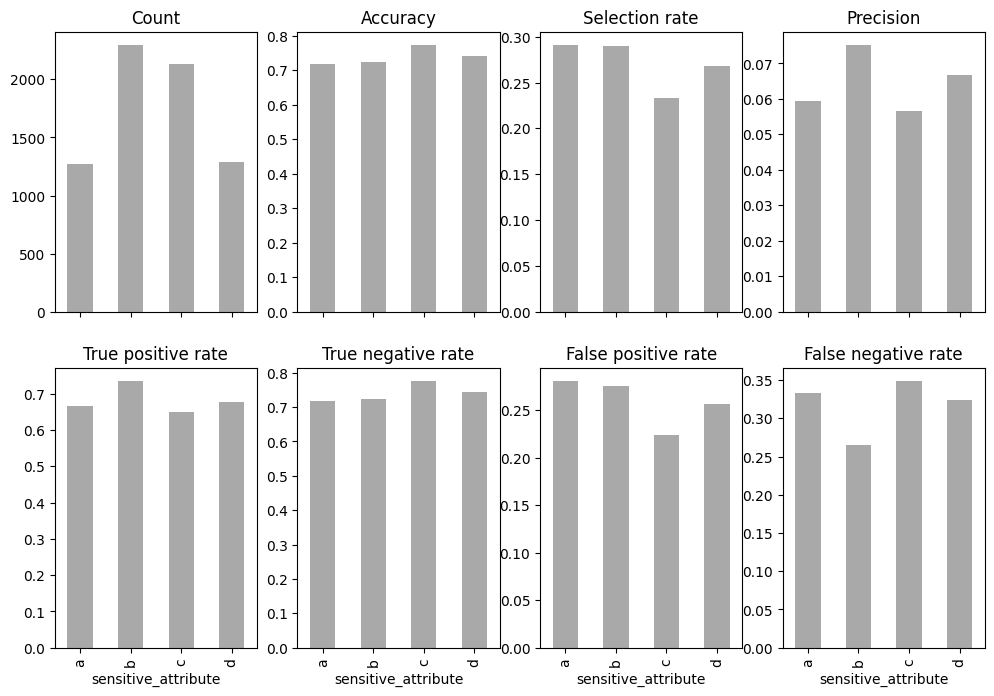

In [ ]:
metrics = {
    "Count": count,
    "Accuracy": accuracy_score,
    "Selection rate": selection_rate,
    "Precision": precision_score,
    "True positive rate": true_positive_rate,
    "True negative rate": true_negative_rate,
    "False positive rate": false_positive_rate,
    "False negative rate": false_negative_rate,

}
metric_frame = MetricFrame(
    metrics=metrics, y_true=fairness_df['true_label'], y_pred=fairness_df['predicted_label'], sensitive_features=fairness_df['sensitive_attribute']
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[2, 4],
    legend=False,
    figsize=[12, 8],
    color='darkgrey'
)

Looking at these plots, we can see some differences between the groups:

* Count: Groups 'a' and 'd' are the smallest, followed by 'c' and 'b' which has the most people.
* Accuracy: all gorups have similar accuracy although group 'c' is notably higher.  
* Selection rate: This is the fraction of observations per group which the model predicts as default. Here we notice a clear descrepancy. Notably group 'c' has the lowest selection rate, meaning that the model is less likley to predict default for the people in this group. Groups 'a' and 'b' have the highest selection rate.  This measure is relevant for assessing the independence criteria.
* Precision: This is the positive predicted value. Group 'b' has the highest value, followed by 'd', 'a' and 'c'. This measure is relevant for assessing the sufficiency criteria.
* True positive rate: This is the recall. Group 'b' has the highest value and the other three all have similar values. This measure is relevant for assessing the separation criteria.
* True negative rate: This is the specificity. All groups have very similar values.
* False positive rate: This is also the type I error. Group 'c' has the lowest value and group 'd' the second lowest value. Groups 'a' and 'b' have the highest values. This measure is relevant for assessing the separation criteria.
* False negative rate: This is also the type II error. Group 'c' has the highest value and group 'b' the lowest value. Groups 'a' and 'd' have similar values.

We can also inspect the dataframe to get summary statistics about the differences, ratio, group minimum and maximum as follows.



In [ ]:
pd.DataFrame({'difference': metric_frame.difference(),
              'ratio': metric_frame.ratio(),
              'group_min': metric_frame.group_min(),
              'group_max': metric_frame.group_max()}).T

,Count,Accuracy,Selection rate,Precision,True positive rate,True negative rate,False positive rate,False negative rate
difference,1023.000000,0.055579,0.058126,0.018736,0.084131,0.056734,0.056734,0.084131
ratio,0.554248,0.928132,0.800172,0.750806,0.885581,0.926877,0.798008,0.758824
group_min,1272.000000,0.717767,0.232755,0.056452,0.651163,0.719128,0.224138,0.264706
group_max,2295.000000,0.773346,0.290881,0.075188,0.735294,0.775862,0.280872,0.348837


In [ ]:
0.23/0.29

0.7931034482758622

Lets look more closely at the 3 fairness criteria.

### Independence
To assess the level of indepenece of the sensitive attribute in the model we measure the demopgraphic parity.

First we measure the difference and then the ratio using the specialized methods in the fairlearn library.


In [ ]:
from fairlearn.metrics import demographic_parity_difference
from fairlearn.metrics import demographic_parity_ratio


DPD = demographic_parity_difference(y_true=fairness_df['true_label'],
                               y_pred=fairness_df['predicted_label'],
                                sensitive_features=fairness_df['sensitive_attribute'],
                                method="between_groups")

DPR = demographic_parity_ratio(y_true=fairness_df['true_label'],
                               y_pred=fairness_df['predicted_label'],
                                sensitive_features=fairness_df['sensitive_attribute'],
                                method='between_groups')

print(f'Demographic parity difference: {DPD:.3f}')
print(f'Demographic parity ratio: {DPR:.3f}')

Demographic parity difference: 0.058
Demographic parity ratio: 0.800


We see some slight evidence of demographic parity, as the DPD is greater than 0 and DPR is less than 1.

### Separation
Next we measure the separation using equalized odds and equal opportunity.

Equalized odds looks at both false positive and true positive rates, and we can compute their difference and ratio.

In [ ]:
from fairlearn.metrics import equalized_odds_difference
from fairlearn.metrics import equalized_odds_ratio

EOD=equalized_odds_difference(y_true=fairness_df['true_label'],
                               y_pred=fairness_df['predicted_label'],
                                sensitive_features=fairness_df['sensitive_attribute'],
                                method="between_groups")

EOR=equalized_odds_ratio(y_true=fairness_df['true_label'],
                               y_pred=fairness_df['predicted_label'],
                                sensitive_features=fairness_df['sensitive_attribute'],
                                method="between_groups")

print(f'Equalized odds difference: {EOD:.3f}')
print(f'Equalized odds ratio: {EOR:.3f}')

Equalized odds difference: 0.084
Equalized odds ratio: 0.798


Again, we see slight evidence of unfairness.

Equal opportunity is based on the true positive rate only. We compute their difference and ratio.

In [ ]:
from fairlearn.metrics import equal_opportunity_difference
from fairlearn.metrics import equal_opportunity_ratio

EOpD=equal_opportunity_difference(y_true=fairness_df['true_label'],
                               y_pred=fairness_df['predicted_label'],
                                sensitive_features=fairness_df['sensitive_attribute'],
                                method="between_groups")

EOpR=equal_opportunity_ratio(y_true=fairness_df['true_label'],
                               y_pred=fairness_df['predicted_label'],
                                sensitive_features=fairness_df['sensitive_attribute'],
                                method="between_groups")
print(f'Equal opportunity difference: {EOpD:.3f}')
print(f'Equa opportunity ratio: {EOpR:.3f}')

Equal opportunity difference: 0.084
Equa opportunity ratio: 0.886


The results are very similar.


#### ROC analysis of separation
By plotting a ROC curve per group we can visally inspect the level of separation in the dataset.

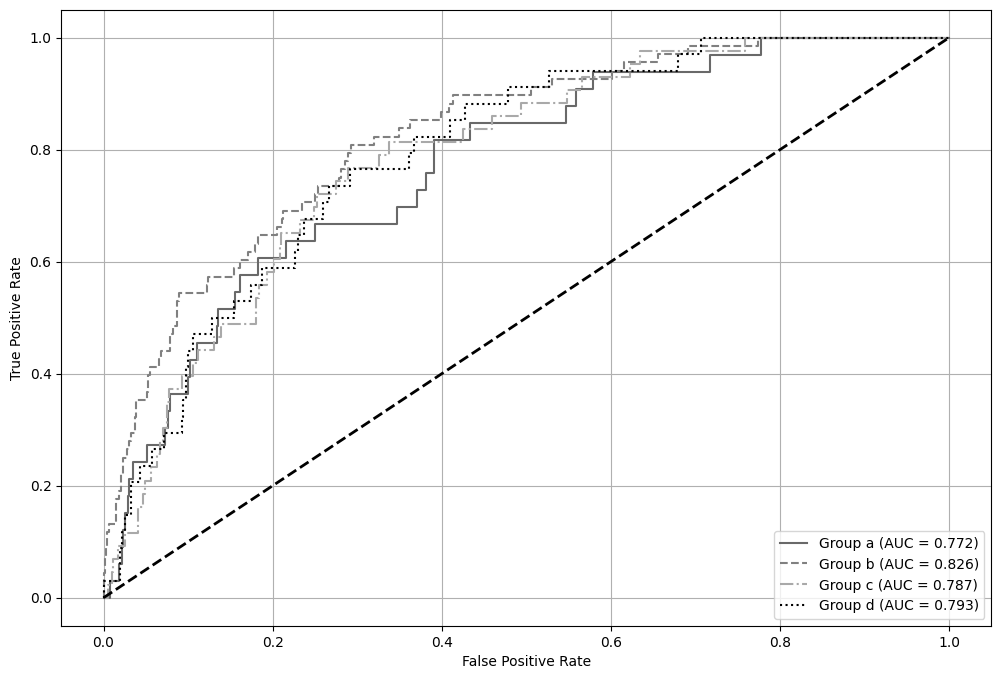

In [ ]:
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(12, 8))

groups = ['a','b','c','d']
line_styles = ['-', '--', '-.', ':']
line_color=['dimgray','gray','darkgrey','black'] # Different dash styles for each group

for i, r in enumerate(groups):
    indices = fairness_df['sensitive_attribute'] == r
    y_true = fairness_df['true_label'][indices]
    y_pred = fairness_df['predicted_probability'][indices]
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=line_color[i % len(line_color)], linestyle=line_styles[i % len(line_styles)], label=f'Group {r} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve by Group')
plt.legend(loc='lower right')
plt.grid()
plt.show()

By shading the are that is under all the curves shows the feasible region where seperation could be achieved.

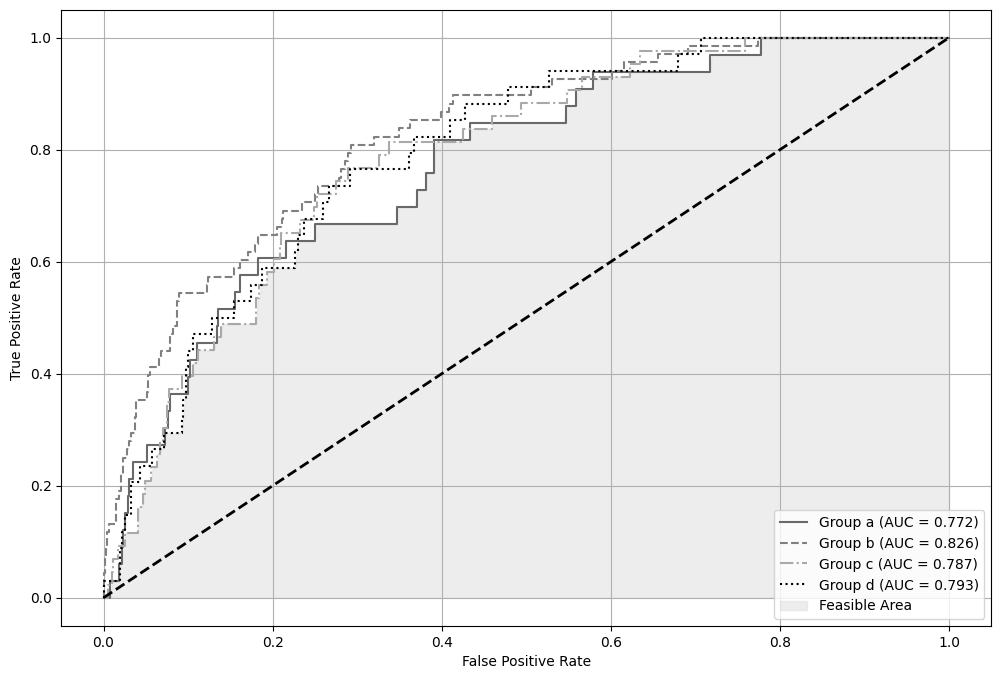

In [ ]:
plt.figure(figsize=(12, 8))

roc_curves = []

groups = ['a','b','c','d']
line_styles = ['-', '--', '-.', ':']
line_color=['dimgray','gray','darkgrey','black']

for i,r in enumerate(groups):
    indices = fairness_df['sensitive_attribute'] == r
    y_true = fairness_df['true_label'][indices]
    y_pred = fairness_df['predicted_probability'][indices]
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=line_color[i % len(line_color)], linestyle=line_styles[i % len(line_styles)],label=f'Group {r} (AUC = {roc_auc:.3f})')
    roc_curves.append((fpr, tpr))


common_fpr = np.linspace(0, 1, 500)
interp_tprs = [np.interp(common_fpr, fpr, tpr) for fpr, tpr in roc_curves]
min_tpr = np.min(interp_tprs, axis=0)

plt.fill_between(common_fpr, min_tpr, color='gainsboro', alpha=0.5, label='Feasible Area')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve by Group with Intersection Area Shaded')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### Sufficiency
Sufficiency requires independence between the sensitive attribute and the target variable, in the sense that people who get the same decision by the model have parity regardless of which group of $A$ they belong to.

We assess sufficiecny by measuring the predictive rate parity which takes into account the precision of the models per group of the sensitive feature. We already have this measure in our dataframe.

We see in the output below that the predictive reate parity close to 0, meaning that in this regard the model fullfills the sufficiency fairness criteria.

In [ ]:
metric_frame.difference()

Count                  1023.000000
Accuracy                  0.055579
Selection rate            0.058126
Precision                 0.018736
True positive rate        0.084131
True negative rate        0.056734
False positive rate       0.056734
False negative rate       0.084131
dtype: float64

### Summary

### Explainability
To create the plots in the book


In [ ]:
%%Generated

This chapter focuses on the critical topic of model explainability in the context of financial text analysis, demonstrating how to interpret the predictions of a sophisticated transformer model. Building on the previous chapter's case study, the notebook utilizes a pre-trained DistilBERT model that classifies Federal Reserve speeches as indicative of economic expansion or contraction. The primary goal is to move beyond "black box" predictions and provide actionable insights into why the model makes a particular decision. This is achieved through the implementation of SHAP (SHapley Additive exPlanations), a state-of-the-art, game-theoretic approach to explainable AI that assigns an importance value to each feature (in this case, words or tokens) for a given prediction.

The notebook guides the user through the process of loading the fine-tuned classification model and a new set of recent, unseen Federal Reserve speeches. It then sets up a SHAP Explainer using the model's prediction pipeline. The core of the lab involves generating SHAP values for these new speeches to understand which specific words or phrases contributed most significantly to the model's output. The chapter culminates in the visualization of these explanations, using SHAP's text and bar plots to highlight the tokens that either support or oppose the predicted economic outcome. This hands-on application of XAI (Explainable AI) not only reinforces the principles of responsible AI development but also aligns with the Banking Analytics Lab's commitment to providing transparent and rigorous data-driven solutions for the financial industry.


In [ ]:
# Imports
import numpy as np
import os
import pandas as pd
import random
import shap

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
%matplotlib inline

# Huggingface
import transformers
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers.pipelines import pipeline
from transformers import set_seed
from datasets import load_dataset, Dataset, Value, ClassLabel, Features, load_from_disk
#import evaluate

In [ ]:
!gdown --id "1_KqbURS8BVRck9mj4DXjuRbD9SJIuz5r"

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1_KqbURS8BVRck9mj4DXjuRbD9SJIuz5r
To: /content/FEDSpeechesSHAP.csv
100% 96.5k/96.5k [00:00<00:00, 12.1MB/s]


In [ ]:
!gdown --id '1ps8vhnNrMFyNbhLtO79UbsNEpiNZesEd'

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ps8vhnNrMFyNbhLtO79UbsNEpiNZesEd
From (redirected): https://drive.google.com/uc?id=1ps8vhnNrMFyNbhLtO79UbsNEpiNZesEd&confirm=t&uuid=352feda8-1f3f-4aec-be09-d5f4e4a207ef
To: /content/FEDSppechModel.zip
100% 247M/247M [00:04<00:00, 57.9MB/s]


In [ ]:
!unzip '/content/FEDSppechModel.zip'

Archive:  /content/FEDSppechModel.zip
   creating: FEDSppechModel/
  inflating: __MACOSX/._FEDSppechModel  
  inflating: FEDSppechModel/model.safetensors  

In [ ]:
!gdown --id '1cqnUWh84nbbwfkcEfUGyPztWOtIeqOEf'

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1cqnUWh84nbbwfkcEfUGyPztWOtIeqOEf
To: /content/TokenizedData.zip
100% 12.6M/12.6M [00:00<00:00, 82.5MB/s]


In [ ]:
!unzip '/content/TokenizedData.zip'

Archive:  /content/TokenizedData.zip
   creating: TokenizedData/
  inflating: __MACOSX/._TokenizedData  
  inflating: TokenizedData/.DS_Store  
  inflating: __MACOSX/TokenizedData/._.DS_Store  
  inflating: TokenizedData/dataset_dict.json  
  inflating: __MACOSX/TokenizedData/._dataset_dict.json  
   creating: TokenizedData/test/
  inflating: __MACOSX/TokenizedData/._test  
   creating: TokenizedData/train/
  inflating: __MACOSX/TokenizedData/._train  
  inflating: TokenizedData/test/state.json  
  inflating: __MACOSX/TokenizedData/test/._state.json  
  inflating: TokenizedData/test/dataset_info.json  
  inflating: __MACOSX/TokenizedData/test/._dataset_info.json  
  inflating: TokenizedData/test/data-00000-of-00001.arrow  
  inflating: __MACOSX/TokenizedData/test/._data-00000-of-00001.arrow  
  inflating: TokenizedData/train/state.json  
  inflating: __MACOSX/TokenizedData/train/._state.json  
  inflating: TokenizedData/train/dataset_info.json  
  inflating: __MACOSX/TokenizedData/trai

In [ ]:
FEDspeechesSHAP = pd.read_csv('/content/FEDSpeechesSHAP.csv')
FEDspeechesSHAP.head()

,date,text,year,month,CFNAI,text_cleaned
0,2024-12-08,For release on delivery\n4:30 p.m. EST\nJanuar...,2025,1,NaN,release delivery est january 8 2024 new year r...
1,2024-12-03,Adriana D Kugler: A year in review - a tale of...,2025,1,NaN,adriana kugler year review tale two supply sho...
2,2024-12-02,Christopher J Waller: Cut or skip?\nSpeech by ...,2025,1,NaN,christopher j waller cut skip speech mr christ...


In [ ]:

speech1 = FEDspeechesSHAP.iloc[0]['text_cleaned']
speech2 = FEDspeechesSHAP.iloc[1]['text_cleaned']
speech3 = FEDspeechesSHAP.iloc[2]['text_cleaned']

print(len(speech1))
print(len(speech2))
print(len(speech3))

18303
11984
9148


In [ ]:
# Create the dataset
fed_speech_data = Dataset.from_pandas(FEDspeechesSHAP.loc[:,['text_cleaned']])
fed_speech_data

Dataset({
    features: ['text_cleaned'],
    num_rows: 3
})

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased",  processing_class=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text_cleaned"], max_length=512, truncation=True)




In [ ]:
tokenized_fed_speech_data = fed_speech_data.map(preprocess_function)

Map:   0%|          | 0/3 [00:00<?, ? examples/s]

Dataset({
    features: ['text_cleaned', 'input_ids', 'attention_mask'],
    num_rows: 3
})

In [ ]:
pipe = transformers.pipelines.pipeline('text-classification', truncation= True,model='FEDSppechModel', tokenizer=tokenizer, top_k=None,
                                  return_all_scores=True, device=0)


Device set to use cpu


In [ ]:
pipe(tokenized_fed_speech_data['text_cleaned'])

[[{'label': 'LABEL_1', 'score': 0.8475385904312134},
  {'label': 'LABEL_0', 'score': 0.1524614691734314}],
 [{'label': 'LABEL_1', 'score': 0.8160449266433716},
  {'label': 'LABEL_0', 'score': 0.183955118060112}],
 [{'label': 'LABEL_1', 'score': 0.8398987650871277},
  {'label': 'LABEL_0', 'score': 0.16010130941867828}]]

In [ ]:
explainer = shap.Explainer(pipe)

In [ ]:
shap_values=explainer(tokenized_fed_speech_data['text_cleaned'])

Token indices sequence length is longer than the specified maximum sequence length for this model (2463 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 1/3 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 3/3 [14:15<00:00, 209.53s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 4it [21:09, 423.03s/it]


In [ ]:
shap_values.shape

(3, None, 2)

In [ ]:
shap.plots.text(shap_values)

Output hidden; open in https://colab.research.google.com to view.

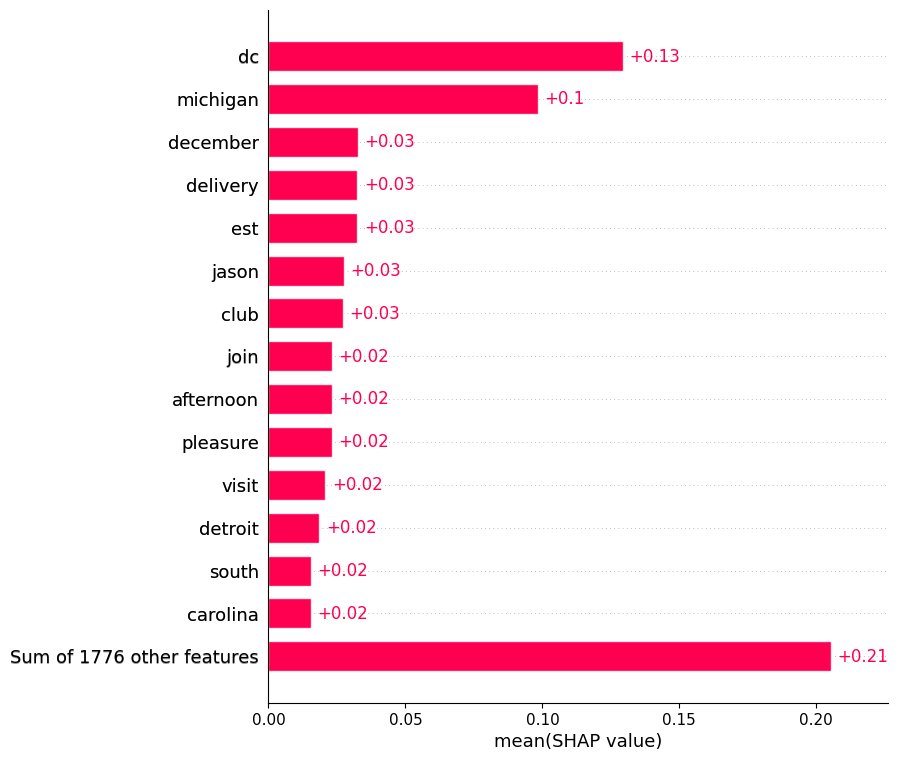

In [ ]:
shap.plots.bar(shap_values[:,:,1].mean(0),order=shap.Explanation.argsort.flip, max_display=15)